# DESAFIO KKD CUP 2009

* Yuri Müller Plumm Gomes
* yurimullergomes@gmail.com



### A tarefa aqui será classificar os três comportamentos de clientes citados acima a partir de dados do tipo customer relationship management (CRM).
- Obs: utilizarei a versão pequena dos dados. 


### Importando bibliotecas e fixando algumas configurações iniciais.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support,roc_auc_score)
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["upselling","appetency" ,"churn"]
CLASS = ['NEG','POS']

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Abrindo os arquivos com os dados:

In [2]:
file_object = pd.read_csv('orange_small_train.data',sep = '\t')
y1 = pd.read_csv('orange_small_train_upselling.labels',sep = '\n')
y1.columns = ['upselling']
y2 = pd.read_csv('orange_small_train_appetency.labels',sep = '\n' )
y2.columns =['appetency']
y3 = pd.read_csv('orange_small_train_churn.labels',sep = '\n')
y3.columns = ['churn']

file_object.describe()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var209,Var230
count,702.000000,1241.000000,1240.000000,1579.000000,1.487000e+03,44471.000000,44461.000000,0.0,702.000000,1.487000e+03,...,1.241000e+03,1241.000000,0.0,702.000000,702.00000,1241.000000,21022.000000,333.000000,0.0,0.0
mean,11.487179,0.004029,425.298387,0.125396,2.387933e+05,1326.437116,6.809496,NaN,48.145299,3.926057e+05,...,7.777380e+04,8.460919,NaN,3.299145,16.54416,167.368477,270.142137,22007.045192,NaN,NaN
std,40.709951,0.141933,4270.193518,1.275481,6.441259e+05,2685.693668,6.326053,NaN,154.777855,9.280896e+05,...,2.016188e+05,46.973777,NaN,8.781967,60.22303,113.980072,86.707692,29085.146490,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,0.000000,0.000000e+00,...,0.000000e+00,0.000000,NaN,0.000000,0.00000,-6.420000,6.000000,0.000000,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,518.000000,0.000000,NaN,4.000000,0.000000e+00,...,0.000000e+00,0.000000,NaN,0.000000,0.00000,19.380000,204.000000,2732.670000,NaN,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,861.000000,7.000000,NaN,20.000000,0.000000e+00,...,0.000000e+00,0.000000,NaN,0.000000,4.00000,197.640000,270.000000,12668.940000,NaN,NaN
75%,16.000000,0.000000,0.000000,0.000000,1.187425e+05,1428.000000,7.000000,NaN,46.000000,2.628630e+05,...,4.881000e+04,8.000000,NaN,6.000000,14.00000,252.960000,330.000000,29396.340000,NaN,NaN
max,680.000000,5.000000,130668.000000,27.000000,6.048550e+06,131761.000000,140.000000,NaN,2300.000000,1.232559e+07,...,3.048400e+06,1200.000000,NaN,102.000000,910.00000,628.620000,642.000000,230427.000000,NaN,NaN


## Pré-processamento: Os dados contém variáveis nulas e variáveis não-numéricas. Precisamos trabalhar nesses dois aspectos antes de utilizar os dados para a classificção.

### Substituindo variáveis nulas pela média da variável:

In [3]:

file_object = file_object.fillna(file_object.mean())


### Retirando as variáveis não-numéricas:

In [4]:
var_drop = []

for i in range(file_object.shape[1]-40, file_object.shape[1]+1):
    value = 0
    value = 'Var{}'.format(i)
    var_drop.append(value)

### Últimos ajustes:

In [5]:
file_object = file_object.drop(var_drop,axis=1)
file_object = file_object.fillna(0)

### Salvando os dados pre-processados:

In [6]:
file_object.to_pickle("data_hekima.pkl")

### Abrindo arquivo com dados pré-processados

In [7]:
data = pd.read_pickle("data_hekima.pkl")

In [8]:
data.shape,y1.shape

((50000, 189), (49999, 1))

### Retirando a última linha da tabela 'data' para compatibilidade entre número de variáveis e o número de eventos categorizados nos arquivos 'labels'  

In [9]:
data = data.drop(49999)
data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189
0,11.487179,0.004029,425.298387,0.125396,238793.32885,1526.000000,7.0,0.0,48.145299,392605.656355,...,3.776755e+06,0.0,1.416638e+06,77773.795326,8.460919,0.0,3.299145,16.54416,167.368477,462.000000
1,11.487179,0.004029,425.298387,0.125396,238793.32885,525.000000,0.0,0.0,48.145299,392605.656355,...,3.776755e+06,0.0,1.416638e+06,77773.795326,8.460919,0.0,3.299145,16.54416,167.368477,270.142137
2,11.487179,0.004029,425.298387,0.125396,238793.32885,5236.000000,7.0,0.0,48.145299,392605.656355,...,3.776755e+06,0.0,1.416638e+06,77773.795326,8.460919,0.0,3.299145,16.54416,167.368477,270.142137
3,11.487179,0.004029,425.298387,0.125396,238793.32885,1326.437116,0.0,0.0,48.145299,392605.656355,...,3.776755e+06,0.0,1.416638e+06,77773.795326,8.460919,0.0,3.299145,16.54416,167.368477,270.142137
4,11.487179,0.004029,425.298387,0.125396,238793.32885,1029.000000,7.0,0.0,48.145299,392605.656355,...,3.776755e+06,0.0,1.416638e+06,77773.795326,8.460919,0.0,3.299145,16.54416,167.368477,270.142137


### Transladando os valores -1,+1 para 0, 1 e concatenando todos os dados em uma única tabela:

In [10]:
y1 = (y1+1)/2 #colocando o label entre 0 e 1
y2 = (y2+1)/2 #colocando o label entre 0 e 1
y3 = (y3+1)/2 #colocando o label entre 0 e 1
yy = pd.concat([y1,y2,y3], axis=1)
data_f = pd.concat([data,yy],axis=1)
yy.head()

,upselling,appetency,churn
0,0.0,0.0,1.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [11]:
LABELS

['upselling', 'appetency', 'churn']

c:\programdata\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


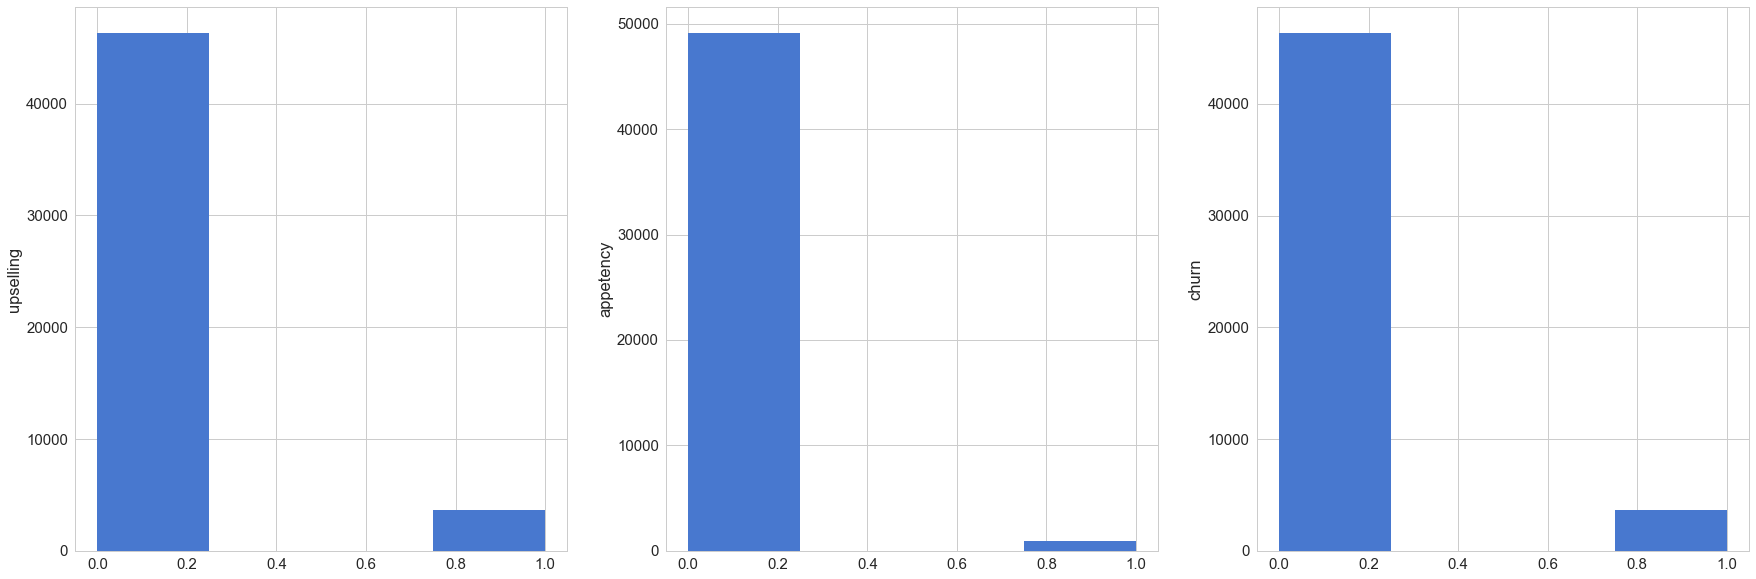

In [12]:
fig = plt.figure(figsize=(30, 10))


plt.subplot(131)
ax0 = yy.upselling.hist(bins=4)

ax0.set_ylabel('{}'.format(LABELS[0]))
plt.subplot(132)
ax1 = yy.appetency.hist(bins=4)

ax1.set_ylabel('{}'.format(LABELS[1]))
plt.subplot(133)
ax2= yy.churn.hist(bins=4)

ax2.set_ylabel('{}'.format(LABELS[2]))
plt.legend()

In [13]:
print('proporção p/ Up-selling - Negativo: {} , Positivo: {}'.format(yy.upselling[yy.upselling==0].count()/(yy.upselling[yy.upselling==0].count()+yy.upselling[yy.upselling==1].count()),yy.upselling[yy.upselling==1].count()/(yy.upselling[yy.upselling==0].count()+yy.upselling[yy.upselling==1].count())))
print('proporção p/ appetency - Negativo: {} , Positivo: {}'.format(yy.appetency[yy.appetency==0].count()/(yy.appetency[yy.appetency==0].count()+yy.appetency[yy.appetency==1].count()),yy.appetency[yy.appetency==1].count()/(yy.appetency[yy.appetency==0].count()+yy.appetency[yy.appetency==1].count())))
print('proporção p/ churn - Negativo: {} , Positivo: {}'.format(yy.churn[yy.churn==0].count()/(yy.churn[yy.churn==0].count()+yy.churn[yy.churn==1].count()),yy.churn[yy.churn==1].count()/(yy.churn[yy.churn==0].count()+yy.churn[yy.churn==1].count())))

proporção p/ Up-selling - Negativo: 0.9263585271705435 , Positivo: 0.07364147282945659
proporção p/ appetency - Negativo: 0.9821996439928798 , Positivo: 0.01780035600712014
proporção p/ churn - Negativo: 0.9265585311706234 , Positivo: 0.07344146882937659


## Obs: Dados muito desbalanceados! Para tentar contornar este problema utilizarei o método de up-sampling.

* Up-sampling é o processo de duplicação aleatória de observações da classe minoritária, a fim de reforçar o seu sinal. Existem várias maneiras para fazê-lo, mas a maneira mais comum é simplesmente resamplear por substituição.

In [14]:
data_f.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var183,Var184,Var185,Var186,Var187,Var188,Var189,upselling,appetency,churn
0,11.487179,0.004029,425.298387,0.125396,238793.32885,1526.000000,7.0,0.0,48.145299,392605.656355,...,77773.795326,8.460919,0.0,3.299145,16.54416,167.368477,462.000000,0.0,0.0,1.0
1,11.487179,0.004029,425.298387,0.125396,238793.32885,525.000000,0.0,0.0,48.145299,392605.656355,...,77773.795326,8.460919,0.0,3.299145,16.54416,167.368477,270.142137,0.0,0.0,0.0
2,11.487179,0.004029,425.298387,0.125396,238793.32885,5236.000000,7.0,0.0,48.145299,392605.656355,...,77773.795326,8.460919,0.0,3.299145,16.54416,167.368477,270.142137,0.0,0.0,0.0
3,11.487179,0.004029,425.298387,0.125396,238793.32885,1326.437116,0.0,0.0,48.145299,392605.656355,...,77773.795326,8.460919,0.0,3.299145,16.54416,167.368477,270.142137,0.0,0.0,0.0
4,11.487179,0.004029,425.298387,0.125396,238793.32885,1029.000000,7.0,0.0,48.145299,392605.656355,...,77773.795326,8.460919,0.0,3.299145,16.54416,167.368477,270.142137,0.0,0.0,0.0


In [15]:
LABELS

['upselling', 'appetency', 'churn']

### Existem três valores-alvo a serem previstos. 
* ``'upselling': propensão para comprar upgrades ou adicionais quando apresentados``
* ``'appetency': a tendência de usar novos produtos e serviços``
* `` 'churn': o cancelamento da conta ``

Começaremos pelo 'upselling':

## Up-selling:

### Seguiremos os seguintes passos:
* Prepararemos os dados, retirando as variáveis indesejáveis;
* Aplicaremos o 'up-sampling' na parte dos dados subrepresentada;
* Dividiremos nossos dados em dados de treino e teste
* Treinaremos o classificador "RandomForestClassifier" com os dados;
* Calcularemos o valor da AUC utilizando o método de k-fold com k = 5;
* Mostraremos a matriz de confusão do classificador (comum e normalizada);

In [16]:
data_final = data_f.drop(['appetency','churn'],axis=1)
df_maj = data_final[data_final.upselling==0]
df_min = data_final[data_final.upselling==1]
df_maj.shape,df_min.shape 
# Upsample minority class
df_min_upsampled = resample(df_min, 
                                replace=True,     # sample with replacement
                                 n_samples=df_maj.shape[0],    # to match majority class
                                 random_state=RANDOM_SEED) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_maj, df_min_upsampled])
df_X = df_upsampled.drop(['upselling'],axis=1)
df_y = df_upsampled['upselling']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values



X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)


rf = RandomForestClassifier(n_estimators = 500, max_features ='sqrt',random_state = RANDOM_SEED,class_weight='balanced')


rf.fit(X_train, y_train);


predictions = rf.predict(X_test)




### Visualizando a matriz de confusão para o classificador:

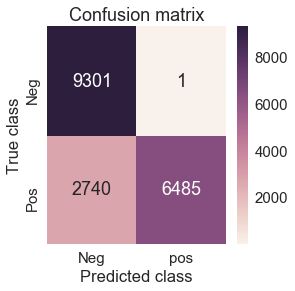

In [17]:

conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'],fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualizando a matriz de confusão normalizada para o classificador:

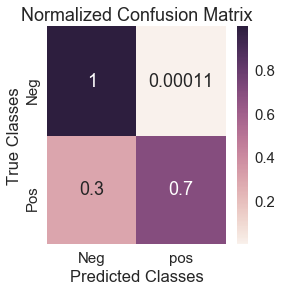

In [18]:
lista = y_test
y_y =pd.DataFrame({'y':lista})
y_test_legit = y_y.y.value_counts()[0]
y_test_fraud = y_y.y.value_counts()[1]
cfn_matrix = confusion_matrix(y_test,predictions)
cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

plt.figure(figsize=(4, 4))
sns.heatmap(norm_cfn_matrix, annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'])
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

In [19]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

        0.0       0.77      1.00      0.87      9302
        1.0       1.00      0.70      0.83      9225

avg / total       0.89      0.85      0.85     18527



### Calculando a AUC para o classificador - 'upselling' :
* aplicando o método k-fold com k=5.

In [20]:
x = df_X.loc[:]
y = df_y.loc[:]

cv = StratifiedKFold(n_splits=5,shuffle=True)
i =0
aucs1 = []
for train,test in cv.split(x,y):
    print('{}%'.format(i*20))
    X_train = x.iloc[train]
    X_test = x.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)
    
    pred = rf.fit(X_train,y_train).predict(X_test)
    aucs1.append(roc_auc_score(y_test, pred))
    i=i+1

AUC1 = '{}+-{}'.format(round(np.average(aucs1), 2),round(np.std(aucs1),2))
print('AUC:', AUC1 )


0%
20%
40%
60%
80%
AUC: 0.8+-0.05


### AUC : 0.80 +-0.05

# ----------------------------------------------------------------------------------------------------------

## 'Appetency':
### Da mesma forma, seguiremos os seguintes passos:
* Prepararemos os dados, retirando as variáveis indesejáveis;
* Aplicaremos o 'up-sampling' na parte dos dados subrepresentada;
* Dividiremos nossos dados em dados de treino e teste
* Treinaremos o classificador "RandomForestClassifier" com os dados;
* Calcularemos o valor da AUC utilizando o método de k-fold com k = 5;
* Mostraremos a matriz de confusão do classificador (comum e normalizada);



In [26]:
data_final = data_f.drop(['upselling','churn'],axis=1)
df_maj = data_final[data_final.appetency==0]
df_min = data_final[data_final.appetency==1]

# Upsample minority class
df_min_upsampled = resample(df_min, 
                                replace=True,     # sample with replacement
                                 n_samples=df_maj.shape[0],    # to match majority class
                                 random_state=RANDOM_SEED) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_maj, df_min_upsampled])
df_X = df_upsampled.drop(['appetency'],axis=1)
df_y = df_upsampled['appetency']


X_train, X_test, y_train, y_test = train_test_split(df_X,df_y ,test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train.values
X_test = X_test.values
y_train = y_train
y_test = y_test

X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

In [27]:
rf = RandomForestClassifier(n_estimators = 500, max_features ='sqrt',random_state = RANDOM_SEED,class_weight='balanced')


rf.fit(X_train, y_train);

predictions = rf.predict(X_test)

### Visualizando a matriz de confusão para o classificador:

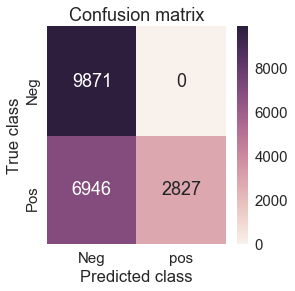

In [28]:

conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'],fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualizando a matriz de confusão normalizada para o classificador:

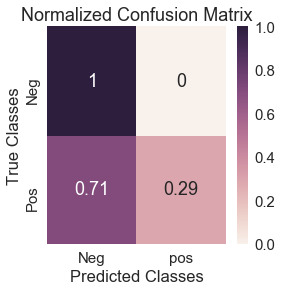

In [29]:
lista = y_test.values
y_y =pd.DataFrame({'y':lista})
y_test_legit = y_y.y.value_counts()[0]
y_test_fraud = y_y.y.value_counts()[1]
cfn_matrix = confusion_matrix(y_test,predictions)
cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

plt.figure(figsize=(4, 4))
sns.heatmap(norm_cfn_matrix, annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'])
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

In [30]:

print(classification_report(y_test,predictions)) 


             precision    recall  f1-score   support

        0.0       0.59      1.00      0.74      9871
        1.0       1.00      0.29      0.45      9773

avg / total       0.79      0.65      0.59     19644



### Calculando a AUC para 'Appetency':
* aplicando o método k-fold com k=5.

In [31]:
x = df_X.loc[:]
y = df_y.loc[:]

cv = StratifiedKFold(n_splits=5,shuffle=True)
i =0
aucs2 = []
for train,test in cv.split(x,y):
    print('{}%'.format(i*20))
    X_train = x.iloc[train]
    X_test = x.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)
    
    pred = rf.fit(X_train,y_train).predict(X_test)
    aucs2.append(roc_auc_score(y_test, pred))
    i=i+1

AUC2 = '{}+-{}'.format(round(np.average(aucs2), 2),round(np.std(aucs2),2))
print('AUC:', AUC2 )


0%
20%
40%
60%
80%
AUC: 0.67+-0.09


### AUC: 0.67+-0.09

# ---------------------------------------------------------------------------------------------------------------

## 'Churn':

### Da mesma forma:
* Prepararemos os dados, retirando as variáveis indesejáveis;
* Aplicaremos o 'up-sampling' na parte dos dados subrepresentada;
* Dividiremos nossos dados em dados de treino e teste
* Treinaremos o classificador "RandomForestClassifier" com os dados;
* Calcularemos o valor da AUC utilizando o método de k-fold com k = 5;
* Mostraremos a matriz de confusão do classificador (comum e normalizada);

In [32]:
data_final = data_f.drop(['appetency','upselling'],axis=1)
df_maj = data_final[data_final.churn==0]
df_min = data_final[data_final.churn==1]
#
# Upsample minority class
df_min_upsampled = resample(df_min, 
                                replace=True,     # sample with replacement
                                 n_samples=df_maj.shape[0],    # to match majority class
                                 random_state=RANDOM_SEED) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_maj, df_min_upsampled])
df_X = df_upsampled.drop(['churn'],axis=1)
df_y = df_upsampled['churn']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values


X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)


rf = RandomForestClassifier(n_estimators = 500, max_features ='sqrt',random_state = 42,class_weight='balanced')


rf.fit(X_train, y_train);


predictions = rf.predict(X_test)



### Visualizando a matriz de confusão para o classificador:

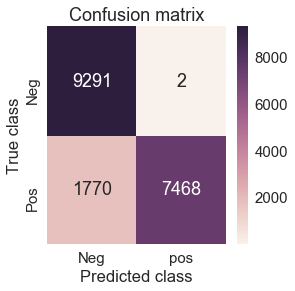

In [33]:

conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'],fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualizando a matriz de confusão normalizada para o classificador:

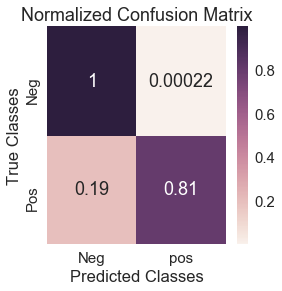

In [34]:
lista = y_test
y_y =pd.DataFrame({'y':lista})
y_test_legit = y_y.y.value_counts()[0]
y_test_fraud = y_y.y.value_counts()[1]
cfn_matrix = confusion_matrix(y_test,predictions)
cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

plt.figure(figsize=(4, 4))
sns.heatmap(norm_cfn_matrix, annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'])
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

In [35]:
print(classification_report(y_test,predictions)) 

             precision    recall  f1-score   support

        0.0       0.84      1.00      0.91      9293
        1.0       1.00      0.81      0.89      9238

avg / total       0.92      0.90      0.90     18531



### Calculando a AUC para o classificador - 'churn' :
* aplicando o método k-fold com k=5.

In [36]:
x = df_X.loc[:]
y = df_y.loc[:]

cv = StratifiedKFold(n_splits=5,shuffle=True)
i =0
aucs3 = []
for train,test in cv.split(x,y):
    print('{}%'.format(i*20))
    X_train = x.iloc[train]
    X_test = x.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)
    
    pred = rf.fit(X_train,y_train).predict(X_test)
    aucs3.append(roc_auc_score(y_test, pred))
    i=i+1

AUC3 = '{}+-{}'.format(round(np.average(aucs3), 2),round(np.std(aucs3),2))
print('AUC:', AUC3 )

0%
20%
40%
60%
80%
AUC: 0.84+-0.07


### AUC: 0.84+-0.07

# ------------------------------------------------------------------------------------------------------------

# RESULTADO FINAL:

Após as etapas de pré-processamento e treinamento obtivemos o valor AUC para o classificador para as três variáveis alvo,  'upselling', 'appetency' e 'churn'. 

In [38]:
AUC1,AUC2,AUC3

('0.8+-0.05', '0.67+-0.09', '0.84+-0.07')

Por fim, obtivemos os seguintes resultados:
* ## ``AUC para 'upselling' : 0.80 ``$\pm $``0.05 ``

* ## ``AUC para 'appetency' : 0.69``$\pm$ ``0.09``

* ## ``AUC para 'churn' : 0.84``$\pm$ ``0.07``

Portanto temos:

## ``AUC_médio = 0.77``$\pm$ ``0.04``

# REFERÊNCIAS:
* https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Intro
* https://scikit-learn.org/stable/supervised_learning.html#supervised-learning
* http://pandas.pydata.org/pandas-docs/stable/